In [86]:
import re
import time
import datetime
import urllib3
import tempfile
import requests
from pprint import pprint
from loguru import logger

import numpy as np 
import pandas as pd 
from pandas import Series, DataFrame

import cv2
import matplotlib.pyplot as plt 
import seaborn as sns 

from tqdm import tqdm
from bs4 import BeautifulSoup

In [2]:
http = urllib3.PoolManager()
url = "https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&pc=30&smk=&po1=25&po2=99&shkr1=03&shkr2=03&shkr3=03&shkr4=03&sc=14102&sc=14109&ta=14&cb=0.0&ct=7.5&md=02&md=03&md=04&md=05&et=9999999&mb=0&mt=35&cn=9999999&fw2="
url = "https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ra=013&rn=0005&ek=000519670&cb=0.0&ct=9.5&mb=20&mt=9999999&et=15&cn=9999999&co=1&shkr1=03&shkr2=03&shkr3=03&shkr4=03&sngz=&po1=04"
response = http.request('GET', url)
soup = BeautifulSoup(response.data, "html.parser")

In [61]:
pages = soup.find_all('ol', class_='pagination-parts')
pages = str(pages)[::-1]
m = re.search(r'\<\d+\>',pages)
max_page_number = int(m.group(0).replace("<", "").replace(">", "")[::-1])
urls = []
urls.append(url)


In [4]:
for i in range(max_page_number - 1):
    page_num = str(i + 2)
    url_page = url + '&pn=' + page_num
    urls.append(url_page)

In [44]:
names = [] #マンション名
addresses = [] #住所
locations0 = [] #立地1つ目（最寄駅/徒歩~分）
locations1 = [] #立地2つ目（最寄駅/徒歩~分）
locations2 = [] #立地3つ目（最寄駅/徒歩~分）
ages = [] #築年数
heights = [] #建物高さ
floors = [] #階
rent = [] #賃料
admin = [] #管理費
others = [] #敷/礼/保証/敷引,償却
floor_plans = [] #間取り
areas = [] #専有面積
detail_urls = [] # 詳細URL
whole_imgs = [] # list of imgs as string

In [45]:
def imread_web(url):
    # 画像をリクエストする
    res = requests.get(url)
    img = None
    # Tempfileを作成して即読み込む
    with tempfile.NamedTemporaryFile(dir='./') as fp:
        fp.write(res.content)
        fp.file.seek(0)
        img = cv2.imread(fp.name)
    return img

def show(img, figsize=(10,6), is_cv2=True):
    if is_cv2:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.figure(figsize=figsize)
    plt.imshow(img)




In [46]:
# Run scraper

# Serch for each page
for step_n, url in tqdm(enumerate(urls),total=len(urls)):
    #logger.info(f"Running for step: {str(step_n)}/{str(len(urls))}")
    response = http.request('GET', url)
    soup = BeautifulSoup(response.data, "html.parser")

    apartments = soup.find_all('div', class_='cassetteitem')

## Search for each apartment
    for apart_n, apartment in enumerate(apartments):
        #logger.info(f"Running for step: {str(apart_n)}/{str(len(apartments))}")

        room_number = len(apartment.find_all('tbody'))

        name = apartment.find('div', class_='cassetteitem_content-title').text
        address = apartment.find('li', class_='cassetteitem_detail-col1').text

        for i in range(room_number):
            names.append(name)
            addresses.append(address)

### Get imgs
        img_srtings = apartment.find_all('div', class_='casssetteitem_other-thumbnail js-view_gallery_images js-noContextMenu')

        if len(img_srtings) == 0:
            whole_imgs.append(None)
        for i in img_srtings:
            imgs = i.attrs['data-imgs']
            imgs = imgs.rsplit(",")
            whole_imgs.append(imgs)

### Get locations
        #logger.info("Getting sublocation..")
        sublocation = apartment.find('li', class_='cassetteitem_detail-col2')
        cols = sublocation.find_all('div')
        for i in range(len(cols)):
            text = cols[i].find(text=True)
            for j in range(room_number):
                if i == 0:
                    locations0.append(text)
                elif i == 1:
                    locations1.append(text)
                elif i == 2:
                    locations2.append(text)

### Get apartment age and height
        #logger.info("Getting age and height..")
        age_and_height = apartment.find('li', class_='cassetteitem_detail-col3')
        age = age_and_height('div')[0].text
        height = age_and_height('div')[1].text

        for i in range(room_number):
            ages.append(age)
            heights.append(height)

### Get rest of the details
        #logger.info("Getting details data..")
        table = apartment.find('table')
        rows = []
        rows.append(table.find_all('tr'))

        data = []
        for row in rows:
            for tr in row:
                cols = tr.find_all('td')
                if len(cols) != 0:
                    _floor = cols[2].text
                    _floor = re.sub('[\r\n\t]', '', _floor)

                    _rent_cell = cols[3].find('ul').find_all('li')
                    _rent = _rent_cell[0].find('span').text
                    _admin = _rent_cell[1].find('span').text

                    _deposit_cell = cols[4].find('ul').find_all('li')
                    _deposit = _deposit_cell[0].find('span').text
                    _reikin = _deposit_cell[1].find('span').text
                    _others = _deposit + '/' + _reikin

                    _floor_cell = cols[5].find('ul').find_all('li')
                    _floor_plan = _floor_cell[0].find('span').text
                    _area = _floor_cell[1].find('span').text

                    _detail_url = cols[8].find('a')['href']
                    _detail_url = 'https://suumo.jp' + _detail_url

                    text = [_floor, _rent, _admin, _others, _floor_plan, _area, _detail_url]
                    data.append(text)

        for row in data:
            floors.append(row[0])
            rent.append(row[1])
            admin.append(row[2])
            others.append(row[3])
            floor_plans.append(row[4])
            areas.append(row[5])
            detail_urls.append(row[6])

        time.sleep(0.002)


 14%|█▍        | 1/7 [00:01<00:06,  1.06s/it]1 1
1 1
1 1
1 1
1 1
2 2
1 1
1 1
2 2
2 2
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
3 3
1 1
1 1
2 2
2 2
1 1
1 1
1 1
1 1
 29%|██▊       | 2/7 [00:03<00:06,  1.34s/it]1 1
3 3
5 5
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
4 4
1 1
1 1
1 0
3 3
2 2
2 2
1 1
1 1
2 2
1 1
1 1
1 1
1 1
 43%|████▎     | 3/7 [00:05<00:06,  1.56s/it]3 3
2 2
1 1
1 1
1 1
1 1
2 2
1 1
1 1
1 1
1 1
1 1
1 1
1 1
2 2
2 2
1 1
2 2
2 2
2 2
2 2
1 1
1 1
1 1
1 1
2 2
1 1
3 3
1 1
1 1
 57%|█████▋    | 4/7 [00:06<00:04,  1.53s/it]1 1
2 2
2 2
1 1
2 2
1 1
1 1
1 1
1 1
1 1
1 1
1 1
2 2
1 1
1 1
1 1
2 2
1 1
1 1
1 1
1 1
2 2
1 1
1 1
2 2
1 1
1 1
1 1
1 1
1 1
 71%|███████▏  | 5/7 [00:07<00:02,  1.46s/it]1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
6 6
4 4
4 4
2 2
2 2
1 1
1 1
1 1
3 3
2 2
1 1
18 18
5 5
1 1
1 1
2 2
2 2
1 1
1 1
1 1
 86%|████████▌ | 6/7 [00:09<00:01,  1.42s/it]3 3
1 1
1 1
1 1
1 1
2 2
1 1
1 1
1 1
3 3
1 1
3 3
1 1
1 1
1 1
1 1
1 1
1 1
2 2
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
100%|███

In [80]:
sr_names = Series(names)
sr_addresses = Series(addresses)
sr_locations0 = Series(locations0)
sr_locations1 = Series(locations1)
sr_locations2 = Series(locations2)
sr_ages = Series(ages).apply(lambda x:re.findall(r"[-+]?\d*\.\d+|\d+", x)[0] ).astype('int')
sr_heights = Series(heights)
sr_floors = Series(floors)
sr_rent = Series(rent).apply(lambda x:re.findall(r"[-+]?\d*\.\d+|\d+", x)[0] ).apply(lambda x: int(float(x)*10000))
sr_admin = Series(admin).apply(lambda x:0 if x == "-" else int(re.findall(r"[-+]?\d*\.\d+|\d+", x)[0]))
sr_monthly_fee = sr_rent + sr_admin
sr_others = Series(others)
sr_floor_plans = Series(floor_plans)
sr_areas = Series(areas).apply(lambda x:x.replace("m2","")).astype('float32')
sr_detail_urls = Series(detail_urls)

suumo_df = pd.concat([sr_names, sr_addresses, sr_locations0, sr_locations1, sr_locations2, sr_ages, sr_heights, sr_floors, sr_rent, sr_admin, sr_monthly_fee,sr_others, sr_floor_plans, sr_areas, sr_detail_urls], axis=1)

suumo_df.columns=['apartment_name','adress','nearest_station_1','nearest_station_2','nearest_station_3','apartment_age','apartment_height','apartment_floor','rent_fee(yen)','admin_fee', 'monthly_fee', '敷/礼/保証/敷引,償却','room_type','area', 'URL']

today = datetime.date.today()
suumo_df.to_csv(f"{today}_shinjuku.csv")

https://suumo.jp/chintai/jnc_000061026241/?bc=100216832039
https://suumo.jp/chintai/jnc_000061951613/?bc=100216860275
https://suumo.jp/chintai/jnc_000061804152/?bc=100219281678
https://suumo.jp/chintai/jnc_000061717901/?bc=100209942864
https://suumo.jp/chintai/jnc_000061766802/?bc=100216723329
https://suumo.jp/chintai/jnc_000061766803/?bc=100215827828


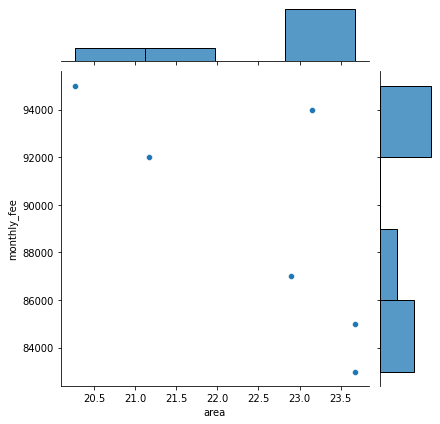

In [79]:
#sns.jointplot(x='area', y='monthly_fee', data=suumo_df, kind='scatter')
screened_df = suumo_df.query("area > 20 and apartment_age < 15")
sns.jointplot(x='area', y='monthly_fee', data=screened_df, kind='scatter')
for i in screened_df['URL']:
    print(i)

In [93]:
today = datetime.date.today()
print(today)

2020-12-19
